In [41]:
import csv
from datetime import datetime
import glob
import os
from io import StringIO
import requests
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from turtle import position

### 測試集資料，資料年份2024/01/01 ~ 2024/03/31

In [42]:
fwd_path = os.path.abspath(os.path.join(os.getcwd(), "..")) #取得當前工作目錄的上一集目錄，並存入路徑
stock_num = ['UNIUSDT_期貨','UNIUSDT_現貨','DYDXUSDT_期貨','DYDXUSDT_現貨']
df = pd.DataFrame()
for i in stock_num:
    file_path = "C:/python/Crypto/Test_Set/"+ i +".csv"
    file = pd.read_csv(file_path, index_col = 'open_time')
    df = df.dropna()
    file = pd.DataFrame(file['close'])
    df = pd.concat([df, file], axis = 1)
df.columns = ['UNIUSDT期貨價格','UNIUSDT現貨價格','DYDXUSDT期貨價格','DYDXUSDT現貨價格']
df = df.dropna()

df['UNIUSDT_Spread'] = df['UNIUSDT期貨價格'] / df['UNIUSDT現貨價格']
df['DYDXUSDT_Spread'] = df['DYDXUSDT期貨價格'] / df['DYDXUSDT現貨價格']
df['Target_Spread'] = df['UNIUSDT_Spread'] / df['DYDXUSDT_Spread']
df['SMA'] = df['Target_Spread'].rolling(15).mean()
df['STD'] = df['Target_Spread'].rolling(15).std()
df['Upper_band'] = df['SMA'] + 1 * df['STD']
df['Lower_band'] = df['SMA'] - 1 * df['STD']
df = df.dropna()
#df.drop(df.tail(100000).index, inplace=True)
print(df)

                     UNIUSDT期貨價格  UNIUSDT現貨價格  DYDXUSDT期貨價格  DYDXUSDT現貨價格  \
open_time                                                                   
2024-01-01 00:14:00        7.573        7.563         3.073         3.070   
2024-01-01 00:15:00        7.586        7.576         3.078         3.076   
2024-01-01 00:16:00        7.575        7.565         3.079         3.078   
2024-01-01 00:17:00        7.590        7.578         3.082         3.079   
2024-01-01 00:18:00        7.591        7.583         3.081         3.078   
...                          ...          ...           ...           ...   
2024-04-25 06:35:00        7.735        7.740         2.236         2.238   
2024-04-25 06:36:00        7.730        7.735         2.233         2.236   
2024-04-25 06:37:00        7.725        7.733         2.229         2.230   
2024-04-25 06:38:00        7.711        7.714         2.228         2.231   
2024-04-25 06:39:00        7.710        7.716         2.225         2.227   

In [43]:
fund = 100000                   
fee = 0.0005            

position = None
profit_list = [0]                      
profit_fee_list = [0]                
executesize = 0                        

for i in range(len(df)):           
    if i == len(df)-1:             
        break

    if position == None:               
        profit_list.append(0)         
        profit_fee_list.append(0)   

        if df['Target_Spread'].iloc[i] < df['Upper_band'].iloc[i] and df['Target_Spread'].iloc[i+1] > df['Upper_band'].iloc[i+1]: 
            position = '空單'                                                                                                                                     
            executesize = (fund) / ( df['UNIUSDT期貨價格'].iloc[i+1] + df['UNIUSDT現貨價格'].iloc[i+1] + df['DYDXUSDT期貨價格'].iloc[i+1] + df['DYDXUSDT現貨價格'].iloc[i+1] ) 
        
        if df['Target_Spread'].iloc[i] > df['Lower_band'].iloc[i] and df['Target_Spread'].iloc[i+1] < df['Lower_band'].iloc[i+1]:                
            position = '多單'                                 
            executesize = (fund) / ( df['UNIUSDT期貨價格'].iloc[i+1] + df['UNIUSDT現貨價格'].iloc[i+1] + df['DYDXUSDT期貨價格'].iloc[i+1] + df['DYDXUSDT現貨價格'].iloc[i+1] )       

    elif position == '空單':                                   
        profit =  ( df['UNIUSDT期貨價格'].iloc[i] - df['UNIUSDT期貨價格'].iloc[i+1]   + df['UNIUSDT現貨價格'].iloc[i+1] - df['UNIUSDT現貨價格'].iloc[i]
                  + df['DYDXUSDT期貨價格'].iloc[i+1] - df['DYDXUSDT期貨價格'].iloc[i] + df['DYDXUSDT現貨價格'].iloc[i] - df['DYDXUSDT現貨價格'].iloc[i+1] ) * executesize
        profit_list.append(profit)

        if  df['Target_Spread'].iloc[i] > (0.75) * df['STD'].iloc[i] and df['Target_Spread'].iloc[i+1] < (0.75) * df['STD'].iloc[i+1] or i == len(df)-2:                    
            pl_round = ( df['UNIUSDT期貨價格'].iloc[i+1] + df['UNIUSDT現貨價格'].iloc[i+1] + df['DYDXUSDT期貨價格'].iloc[i+1] + df['DYDXUSDT現貨價格'].iloc[i+1] ) * executesize
            profit_fee = profit - (fund+pl_round) * fee
            profit_fee_list.append(profit_fee)                       
            position = None        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif position == '多單':                                   
        profit =  ( df['UNIUSDT期貨價格'].iloc[i+1] - df['UNIUSDT期貨價格'].iloc[i]   + df['UNIUSDT現貨價格'].iloc[i] - df['UNIUSDT現貨價格'].iloc[i+1]
                  + df['DYDXUSDT期貨價格'].iloc[i] - df['DYDXUSDT期貨價格'].iloc[i+1] + df['DYDXUSDT現貨價格'].iloc[i+1] - df['DYDXUSDT現貨價格'].iloc[i] ) * executesize
        profit_list.append(profit)

        if  df['Target_Spread'].iloc[i] < (-0.5) * df['STD'].iloc[i] and df['Target_Spread'].iloc[i+1] > (-0.5) * df['STD'].iloc[i+1] or i == len(df)-2:                    
            pl_round = ( df['UNIUSDT期貨價格'].iloc[i+1] + df['UNIUSDT現貨價格'].iloc[i+1] + df['DYDXUSDT期貨價格'].iloc[i+1] + df['DYDXUSDT現貨價格'].iloc[i+1] ) * executesize
            profit_fee = profit - (fund+pl_round) * fee
            profit_fee_list.append(profit_fee)                       
            position = None        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)            

              profit
0       0.000000e+00
1       0.000000e+00
2       0.000000e+00
3      -2.085220e-12
4       1.878199e+01
...              ...
110981  5.634596e+01
110982  5.165047e+01
110983  7.512795e+01
110984  4.225947e+01
110985  6.104146e+01

[110986 rows x 1 columns]
分配金額: 100000
手續費: 0.0005
總獲利(沒扣除手續費): 61.04146123873674


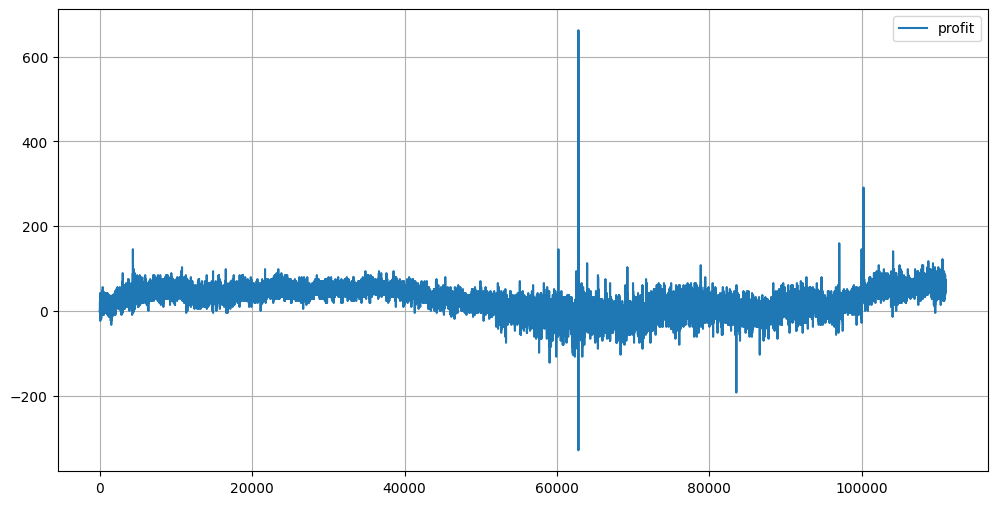

In [44]:
equity_2 = pd.DataFrame({'profit': np.cumsum(profit_list)})
print(equity_2)
equity_2.plot(figsize = (12, 6), grid = True)
A = np.cumsum(profit_fee_list)
B = np.cumsum(profit_list)
last_value2 = B[-1]
last_value = A[-1]
print("分配金額:", fund)
print("手續費:", fee)
print("總獲利(沒扣除手續費):",last_value2)

              profit    profit_fee
0       0.000000e+00  0.000000e+00
1       0.000000e+00  0.000000e+00
2       0.000000e+00  0.000000e+00
3      -2.085220e-12 -2.085220e-12
4       1.878199e+01  1.878199e+01
...              ...           ...
110981  5.634596e+01  5.634596e+01
110982  5.165047e+01  5.165047e+01
110983  7.512795e+01  7.512795e+01
110984  4.225947e+01  4.225947e+01
110985  6.104146e+01 -3.562708e+01

[110986 rows x 2 columns]
分配金額: 100000
手續費: 0.0005
總獲利(沒扣除手續費): 61.04146123873674
總獲利(扣手續費後): -35.62708362673728


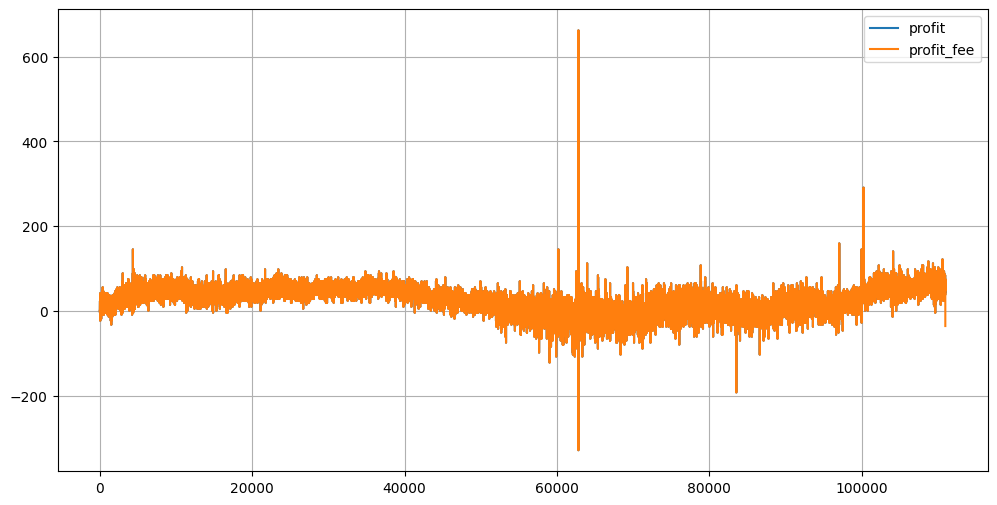

In [45]:
equity_1 = pd.DataFrame({'profit': np.cumsum(profit_list), 'profit_fee': np.cumsum(profit_fee_list)})
print(equity_1)
equity_1.plot(figsize = (12, 6), grid = True)
A = np.cumsum(profit_fee_list)
B = np.cumsum(profit_list)
last_value2 = B[-1]
last_value = A[-1]

print("分配金額:", fund)
print("手續費:", fee)
print("總獲利(沒扣除手續費):",last_value2)
print("總獲利(扣手續費後):", last_value)